In [667]:
!python -c "import torch; print(torch.__version__); print(torch.cuda.is_available())"

1.0.1.post2
True


In [668]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [669]:
HOME_DIR = "/home/mark"

import warnings
warnings.filterwarnings("ignore") # ignore warnings

import sys
sys.path.append("/home/mark/Documents/yolov3/pytorch_yolov3")

# from yolo
from models import *
from utils.utils import *
from utils.datasets import *

# other
import os
import math
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import json
import time
import datetime
import matplotlib
import torchgeometry as tgm

from torch import Tensor
from torch.autograd import Variable
from matplotlib.patches import Rectangle

In [670]:
import os

config = {
  "root_dir": os.path.join(HOME_DIR, "Documents",
  "run-{}".format(datetime.datetime.today().strftime("%Y-%m-%d_%H-%M"))),
  
  "use_gpu": torch.cuda.is_available(),
  "device_number": 0,
}

config["data_path"] = os.path.join(config["root_dir"], "data")
config["yolo_path"] = os.path.join(config["root_dir"], "yolov3/pytorch_yolov3")
config["output_dir"] = os.path.join("outputs-device{}".format(config["device_number"]), config["run_id"]),

config.update({
  "model_config_path": os.path.join(config["yolo_path"], "config/yolov3.cfg"),
  "model_weights_path": os.path.join(config["yolo_path"], "weights/yolov3.weights"),
  "train_path": os.path.join(config["data_path"], "trainvalno5k.txt"),
  "val_path": os.path.join(config["data_path"], "5k.txt"),
  "patch_dir": os.path.join(config["output_dir"], "patches"),
  "checkpoint_dir": os.path.join(config["output_dir"], "tmp"),
  
  "num_workers": 4, # for dataloader
  "train_batch_size": 1,
  "val_batch_size": 1,
  "iou_threshold": 0.5,
  "image_width": 416,
  "class_names": load_classes(os.path.join(config["data_path"], "coco.names")),
  "target_class": 1,
  "lr": 0.1,
  "lr_decay": 0.95,
  "lr_decay_every_n_epochs": 5,
  "momentum": 0.9,
  "weight_decay": 0,
  "max_train_iters": 1000,
  "max_val_iters": 1000,
  "max_train_epochs": 1000,
  "validate_every_n_epochs": 5,
  "checkpoint_every_n_epochs": 5,
  "evaluate_baseline": False,
  "use_optimizer": True,
  "clip_patch": True,
  "use_eot": True,
  
  "resume_checkpoint": None,
  
  # maintain losses in a consistent order:
  # 1. all ground truth as usual
  # 2. ground truth for TARGET_CLASS removed
  # 3. all ground truth removed
  # 4. ground truth set to the patch with TARGET_CLASS (dpatch loss)
  "maximize_loss": [True, False, False, False],
  "target_loss_index": 3,
  "compute_all_losses": False,
  
  "axes": ["x","y","z"] # 0: x, 1: y, 2: z
})

if config["use_eot"]:
  config.update({
    "max_x_rotation": 5,
    "max_y_rotation": 5,
    "max_z_rotation": 10,
    "min_patch_width": 80,
    "max_patch_width": 120,
    "min_brightness": 0.4,
    "max_brightness": 1.6,
  })
else:
  config.update({
    "max_x_rotation": 0,
    "max_y_rotation": 0,
    "max_z_rotation": 0,
    "min_patch_width": 120,
    "max_patch_width": 120,
    "min_brightness": 1,
    "max_brightness": 1,
  })

config.update({
  "target_loss_maximize": config["maximize_loss"][config["target_loss_index"]],
  "num_losses": len(config["maximize_loss"]) if config["compute_all_losses"] else 1,
  "num_classes": len(config["class_names"])
})

print("run config:", config)
print("target loss:", config["target_loss_index"])
print("target class:", config["class_names"][config["target_class"]])

if config["use_gpu"]:
  torch.cuda.set_device(config["device_number"])
  print("using gpu:", torch.cuda.current_device())

run id: run-2019-04-19_21:18
run config: {'resume_checkpoint': None, 'target_loss_index': 3, 'target_loss_maximize': False, 'target_class': 0, 'train_batch_size': 1, 'val_batch_size': 1, 'train_epochs': 1000, 'train_iters': 1000, 'clip_patch': True, 'lr': 0.1, 'lr_decay': 0.95, 'lr_decay_every_n_epochs': 5, 'optimizer': True, 'eot': True, 'patch_width': 120, 'validate_every_n_epochs': 5, 'iou_threshold': 0.5, 'max_rotation': 10, 'train_min_proportion': 0.03698224852071006, 'train_max_proportion': 0.08321005917159763, 'val_min_proportion': 0.03698224852071006, 'val_max_proportion': 0.08321005917159763, 'min_brightness_factor': 0.4, 'max_brightness_factor': 1.6, 'min_axis_rotation': -5.0, 'max_axis_rotation': 5.0, 'momentum': 0.9, 'weight_decay': 0}
target loss: 3
target class: person
using gpu: 0


In [671]:
# setup the output directories and write the run config
for d in [config["patch_dir"], config["checkpoint_dir"]]:
  if not os.path.exists(d):
    os.makedirs(d)
with open(os.path.join(config["output_dir"], "config.json"), "w") as f:
  json.dump(config, f)

In [672]:
# data loading

train_dataset = ListDataset(config["train_path"])
train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=config["train_batch_size"],
  shuffle=True,
  num_workers=config["num_workers"]
)

val_dataset = ListDataset(config["val_path"])
val_loader = torch.utils.data.DataLoader(
  val_dataset,
  batch_size=config["val_batch_size"],
  shuffle=True,
  num_workers=config["num_workers"]
)

In [673]:
# general helpers

def get_batched(tensor, batch_size):
  return tensor.repeat((batch_size,) + (1,) * len(tensor.shape))

def print_summary(name, tensor):
  summary = "{} shape: {}, mean: {:0.5f}, var: {:0.5f}, min: {:0.5f}, max: {:0.5f}".format(
    name, tensor.shape, tensor.mean().item(), tensor.var().item(), 
    tensor.min().item(), tensor.max().item())
  print(summary)
  
# batch matrix scalar product
def bms(mat_batch, scalar_batch):
  # scalar_batch is expected to be a vector of len batch size
  # this allows us to do something like [A,B] * [c,d] = [cA,dB] where A,B are matrices, c,d are scalar factors
  return mat_batch * scalar_batch.reshape((-1,) + (1,) * (mat_batch.dim() - 1))

def square_mask(shape):
  return torch.ones(shape)

In [674]:
# visualization helpers

# expects numpy inputs
def show(images, annotation_batch=None, annotation_color="r", title="", size=(10,10), save_to=None):
  grid_nrow = int(math.sqrt(len(images)))
  grid_ncol = round(len(images) / grid_nrow)
  
  fig, axes = plt.subplots(grid_nrow, grid_ncol, squeeze=False)
  fig.set_size_inches(*size)
  
  if annotation_batch is None:
    annotation_batch = [np.array([])]*len(images)
  
  for i, (image, annotations) in enumerate(zip(images, annotation_batch)):
    axes.flat[i].imshow(image.transpose((1,2,0)))

    for bbox in annotations[np.where(annotations.any(axis=-1))]:
      axes.flat[i].add_patch(Rectangle(
        (bbox[1], bbox[2]),
        bbox[3] - bbox[1],
        bbox[4] - bbox[2],
        linewidth=1,
        edgecolor=annotation_color,
        facecolor="none"))

  plt.title(title)
  if save_to is not None:
    plt.savefig(save_to)
  plt.show()

def get_image_batch():
  for _, images, annotation_batch in train_loader:
    return images, annotation_batch
  
def bbox_to_annotation_batch(bbox_batch):
  res = bbox_batch.clone()
  
  # convert last two coordinates to w,h
  res[:,:,3] -= res[:,:,1]
  res[:,:,4] -= res[:,:,2]
  
  # convert first two coordinates to center
  res[:,:,1] += res[:,:,3] / 2
  res[:,:,2] += res[:,:,4] / 2
  
  # rescale to 0,1
  res[:,:,1:] /= config["image_width"]

  return res

def annotation_to_bbox_batch(annotation_batch):
  res = annotation_batch.clone()
  
  # convert coordinates to top left corner
  res[:,:,1] = annotation_batch[:,:,1] - annotation_batch[:,:,3] / 2
  res[:,:,2] = annotation_batch[:,:,2] - annotation_batch[:,:,4] / 2
  
  # convert coordinates to bottom right corner
  res[:,:,3] = annotation_batch[:,:,1] + annotation_batch[:,:,3] / 2
  res[:,:,4] = annotation_batch[:,:,2] + annotation_batch[:,:,4] / 2
  
  # rescale to image dimensions
  res[:,:,1:] *= config["image_width"]

  return res

images, annotation_batch = get_image_batch()
print(annotation_batch[0,:5])

#   print_summary("images", images)
#   print_summary("annotations", annotation_batch)

# annotation_batch = annotation_to_bbox_batch(annotation_batch)
# show(images.numpy(), annotation_batch=annotation_batch.numpy())

tensor([[5.9000e+01, 6.2141e-01, 7.8027e-01, 4.2280e-01, 4.0359e-01],
        [2.0000e+00, 8.0856e-01, 3.3527e-01, 4.8500e-02, 4.2156e-02],
        [2.0000e+00, 1.8477e-01, 3.2806e-01, 3.6141e-02, 3.4969e-02],
        [2.0000e+00, 1.7625e-01, 3.1829e-01, 2.0938e-02, 3.3172e-02],
        [9.0000e+00, 3.3978e-01, 7.5281e-02, 3.3719e-02, 7.4156e-02]],
       dtype=torch.float64)


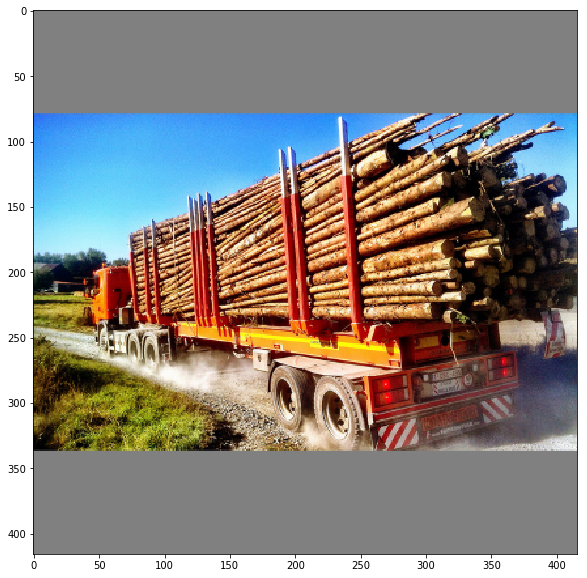

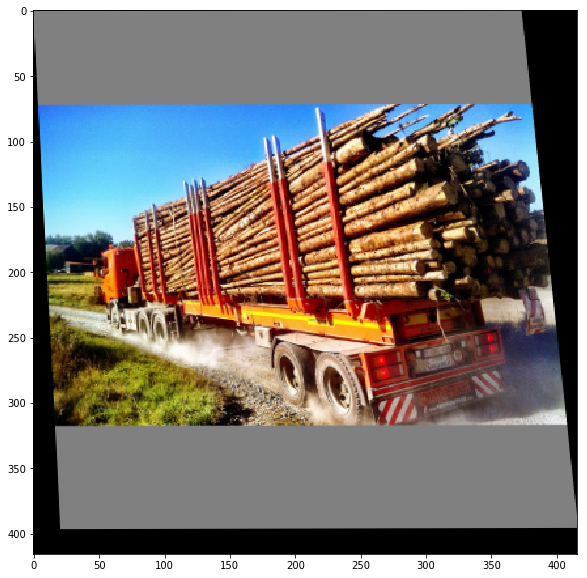

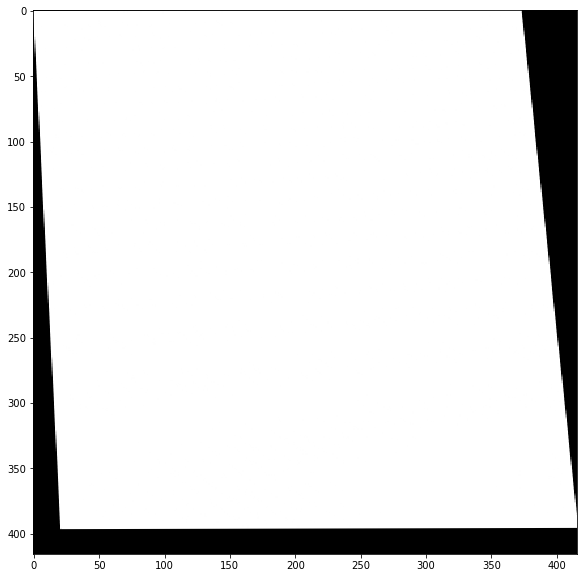

In [675]:
# # get a batch of identity matrices
# def get_eye_batch(batch_size, eye_shape):
#   mat = torch.eye(eye_shape)
#   return mat.reshape((1,eye_shape,eye_shape)).repeat(batch_size,1,1)

# get a batch of quaternions representing some rotation around the provided axis
def get_random_quaternion_batch(batch_size, axis, rotation_range=None):
  if rotation_range is None:
    rotation_range = config["max_{}_rotation".format(config["axes"][axis])]
    rotation_range = (-rotation_range, rotation_range)
  
  theta_batch = torch.rand(batch_size).uniform_(*rotation_range) * np.pi/180.
  q_batch = torch.zeros((batch_size, 4))
  q_batch[:,0] = torch.cos(theta_batch / 2.)
  q_batch[:,1+axis] = torch.sin(theta_batch / 2.)
  return q_batch
  
# see: https://en.wikipedia.org/wiki/Quaternion#Scalar_and_vector_parts
# this is just a batched implementation
def batch_hamilton_product(batch_q1, batch_q2):
  a_batch, u_batch = batch_q1[:,0], batch_q1[:,1:]
  b_batch, v_batch = batch_q2[:,0], batch_q2[:,1:]
  res = torch.zeros((len(batch_q1), 4))
  res[:,0] = a_batch * b_batch - torch.diag(u_batch.mm(v_batch.t())) # diag + mm for batched dot product
  res[:,1:] = bms(v_batch, a_batch) + bms(u_batch, b_batch) + u_batch.cross(v_batch, dim=1)
  return res

# see: https://github.com/arraiyopensource/torchgeometry/blob/master/docs/source/warp_perspective.ipynb
def warp_image_batch(image_batch):
  image_width = config["image_width"]
  batch_size = len(image_batch)
  mask_batch = square_mask(image_batch.shape).to(config["device"])
  
  # z axis rotation is handled by regular rotation
  qx_batch = get_random_quaternion_batch(batch_size, 0).to(config["device"])
  qy_batch = get_random_quaternion_batch(batch_size, 1).to(config["device"])

  q_batch = batch_hamilton_product(qx_batch, qy_batch)
  rot = tgm.quaternion_to_angle_axis(q_batch)
  rot_mat = tgm.angle_axis_to_rotation_matrix(rot)
  
  # top left, top right, bottom right, bottom left
  points_src = torch.FloatTensor([
    [0, 0], [image_width-1, 0], [image_width-1, image_width-1], [0, image_width-1]
  ])
  points_src = get_batched(points_src, batch_size)
  
  # apply rotation to the src points
  points_dst = rot_mat.bmm(points_src)
  
  # compute the extents of points_dst to make sure the warped image stays within IMAGE_WIDTH

  # max and min of each column (axis 0 is batch, so computed over axis 1)
  min_extents = points_dst.min(1)[0]
  max_extents = points_dst.max(1)[0]
  # now take the max of each row (i.e., the max extent among x and y)
  extents = (max_extents - min_extents).max(-1)[0]
  
  # extract the indices of the images that need to be rescaled to fit within IMAGE_WIDTH
  idx = extents > image_width
  
  # shift those images to have origin 0,0 (since scaling is anchored at 0,0)
  points_dst[idx] -= min_extents[idx].unsqueeze(1)
  
  # build batch scale matrices for scaling the selected destination points down
  # for the ones that do not need rescaling, the scale matrix is just eye
  scale_factors = torch.ones(batch_size)
  scale_factors[idx] = (image_width / extents)
  scale_mat_batch = torch.eye(2)
  scale_mat_batch = get_batched(scale_mat_batch, batch_size)
  scale_mat_batch = bms(scale_mat_batch, scale_factors)

  # transpose to get shapes matching, apply the batch scale matrices, transpose back
  points_dst = points_dst.transpose(1,2)
  points_dst = scale_mat_batch.bmm(points_dst)
  points_dst = points_dst.transpose(1,2)
  
  # compute perspective transform
  M = tgm.get_perspective_transform(points_src, points_dst).to(config["device"])

  # warp the original image by the transform
  image_batch = tgm.warp_perspective(image_batch, M, dsize=(image_width, image_width))
  mask_batch = tgm.warp_perspective(mask_batch, M, dsize=(image_width, image_width))
  
  return image_batch, mask_batch
  
def test_warp_image():
  image_batch, _ = get_image_batch()
  # image_batch = torch.rand((2,3,416,416))
  
  image_batch = image_batch.to(config["device"])
  image_batch_warped, mask_batch_warped = warp_image_batch(image_batch)
  
  show(image_batch.cpu().detach().numpy())
  show(image_batch_warped.cpu().detach().numpy())
  show(mask_batch_warped.cpu().detach().numpy())
  
test_warp_image()

patch shape: torch.Size([3, 416, 416]), mean: 0.33333, var: 0.22222, min: 0.00000, max: 1.00000
images shape: torch.Size([1, 3, 500, 300]), mean: 0.50025, var: 0.08340, min: 0.00000, max: 1.00000
tensor([[[  0.0000,  76.3263, 223.7183, 193.5944, 340.9864]]])


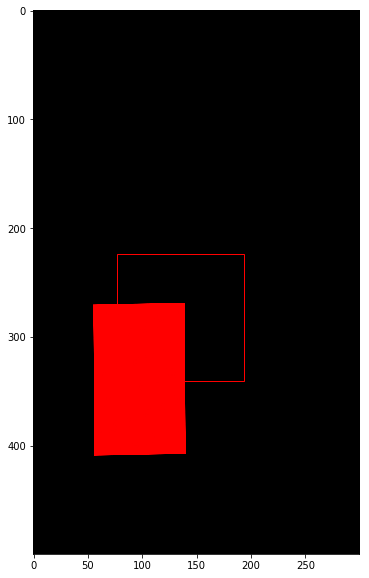

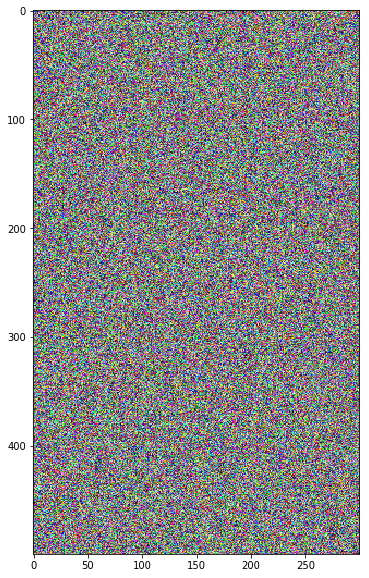

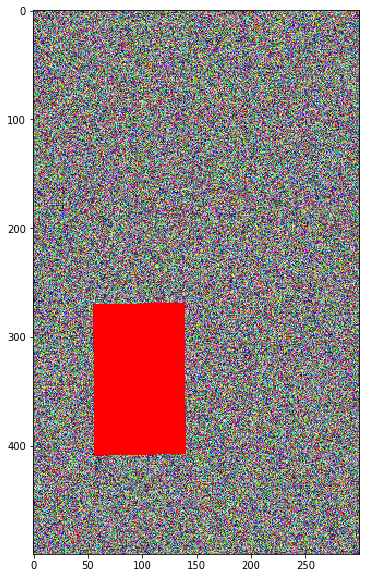

In [687]:
# test the patch and transforms

def empty_patch(random=False, shape=(3, config["image_width"], config["image_width"])):
  if random:
    patch = torch.rand(shape) # random values in [0,1]
  else:
    patch = torch.zeros(shape)
    
#     patch[0,:,:] = 1 # color patch red for testing mask

  patch = patch.to(config["device"])
  return nn.Parameter(data=patch, requires_grad=True)

# image_shape should end with H,W (e.g. (3,416,416))
def get_random_tform(image_shape, rotation_range=(-config["max_z_rotation"], config["max_z_rotation"]), 
                     patch_size_range=(config["max_patch_width"], config["max_patch_width"]), use_eot=config["use_eot"]):
  # sample rotation
  if not use_eot:
    random_rotation = 0
  else:
    random_rotation = np.random.uniform(*rotation_range) * np.pi/180.
  
  image_h, image_w = image_shape[-2:]
  image_max = max(image_h, image_w)
  
  # sample scaling factor
  random_size = np.random.uniform(*patch_size_range)
  random_scale = random_size / image_max

  # translations should be between -1 and 1; -1,-1 is top left, 1,1 is bottom right
  # note that the total "width", "height" is therefore 2, 2
  h_pad = image_h / image_max - random_scale
  w_pad = image_w / image_max - random_scale

  # sample translation
  if use_eot:  
    random_x_delta = np.random.uniform(-w_pad, w_pad)
    random_y_delta = np.random.uniform(-h_pad, h_pad)
  else:
    # fix to top left
    random_x_delta = -w_pad
    random_y_delta = -h_pad
  
  # rotation matrix
  rotate_mat = torch.eye(3)
  rotate_mat[:2,:2] = torch.Tensor([
      [np.cos(random_rotation), -np.sin(random_rotation)],
      [np.sin(random_rotation), np.cos(random_rotation)]
  ])

  # scale matrix
  scale_mat = torch.eye(3) / random_scale
  scale_mat[2,2] = 1.

  # translation matrix
  translate_mat = torch.eye(3)
  translate_mat[:2,2] = torch.Tensor([-random_x_delta, -random_y_delta])
  
  # build transformation matrix
  tform_mat = scale_mat.mm(rotate_mat.mm(translate_mat))
  
  # keep only the top two rows
  return tform_mat[:2,:]

def get_random_tform_batch(image_batch, **kwargs):
  tform_batch = []
  for img in image_batch:
    tform_batch.append(get_random_tform(img.shape, **kwargs))
  return torch.stack(tform_batch)

def adjust_brightness(patch_batch):
  # patch_batch is N,C,H,W
  # if multiplying: <1 is darken, >1 is lighten
  factors = torch.FloatTensor(len(patch_batch)).uniform_(config["min_brightness"], config["max_brightness"]).to(config["device"])
  patch_batch = bms(patch_batch, factors)
  if config["clip_patch"]:
    patch_batch = patch_batch.clamp(0,1)
  return patch_batch

def apply_tform(inputs, affine_grid=None, tform_batch=None):
  if tform_batch is None:
    tform_batch = get_random_tform_batch(inputs)
  if affine_grid is None:
    affine_grid = F.affine_grid(tform_batch, inputs.size())

  return F.grid_sample(inputs, affine_grid)

def crop(image_batch, shape):
  h, w = shape[-2:]
  shape_max = max(h,w)
  
  crop_h = int((shape_max - h) / 2)
  crop_w = int((shape_max - w) / 2)
  
  return image_batch[:,:, crop_h: crop_h + h, crop_w: crop_w + w]

def apply_patch(image_batch, patch, tform_batch):
  batch_size = len(image_batch)
  
  patch_batch = get_batched(patch, batch_size)
  mask_batch = square_mask(image_batch.shape).to(config["device"])
  
  affine_grid = F.affine_grid(tform_batch, mask_batch.shape).to(config["device"])
  mask_batch_tform = apply_tform(mask_batch, affine_grid=affine_grid, tform_batch=tform_batch)
  patch_batch_tform = apply_tform(patch_batch, affine_grid=affine_grid, tform_batch=tform_batch)
  
#   # crop out the letterbox padding to convert square to potentially non-square image shape
#   image_h, image_w = image_batch.shape[-2:]
#   image_max = max(image_h, image_w)
#   h_pad = int((image_max - image_h) / 2)
#   w_pad = int((image_max - image_w) / 2)

#   mask_batch_tform = crop(mask_batch_tform, h_pad, w_pad)
#   patch_batch_tform = crop(patch_batch_tform, h_pad, w_pad)

  # crop out the letterbox padding to convert square to potentially non-square image shape
  mask_batch_tform = crop(mask_batch_tform, image_batch.shape)
  patch_batch_tform = crop(patch_batch_tform, image_batch.shape)
  
  input_batch = (1-mask_batch_tform) * image_batch + mask_batch_tform * patch_batch_tform
  return input_batch, patch_batch_tform

# converts image coordinates to torch coordinates:
# torch coordinates have top left at [-1,-1], bottom right at [1,1]
# image coordinates have top left at [0,0], bottom right at [IMAGE_WIDTH, IMAGE_WIDTH]
def img_to_torch_coord():
  scale_mat = torch.eye(3)
  scale_mat[0,0] /= (config["image_width"]/2) # divide x by IMAGE_WIDTH/2
  scale_mat[1,1] /= (config["image_width"]/2) # divide y by IMAGE_WIDTH/2
  
  translate_mat = torch.eye(3)
  translate_mat[:2,-1] = torch.Tensor([-1.,-1.]) # shift x by -1, y by -1
  
  # scale first, then translate
  return translate_mat.mm(scale_mat)

# converts torch coordinates to image coordinates:
# torch coordinates have top left at [-1,-1], bottom right at [1,1]
# image coordinates have top left at [0,0], bottom right at [IMAGE_WIDTH, IMAGE_WIDTH]
def torch_to_img_coord():
  return torch.inverse(img_to_torch_coord())

# get the top left corner and bottom right corner of the patch after transformation
def get_patch_bbox_batch(tform_batch):
  # convert transforms to 3x3 (from 2x3, by filling bottom row with [0,0,1])
  tform_ = torch.zeros((len(tform_batch), 3, 3))
  tform_[:,:2,:] = tform_batch
  tform_[:,2,2] = 1.
  
  # invert the transform since the matrices generated by get_random_tform 
  # are inverse of what we actually want
  tform_ = torch.inverse(tform_)
  
  # we want to figure out where the top left and bottom right corners of the patch
  # end up after we apply the transforms, which we can do easily by multiplying the
  # transformation matrices
  test_points = torch.FloatTensor([
    [-1.,-1.,1.], # top left in torch coordinates
    [1.,-1.,1.], # top right in torch coordinates
    [-1.,1.,1.], # bot left in torch coordinates
    [1.,1.,1.] # bot right in torch coordinates
  ])
  test_points = torch.transpose(test_points,0,1) # transpose to get the shapes matching
  test_points = get_batched(test_points, len(tform_batch))
  test_points = tform_.bmm(test_points)
  
  # we now have the transformed corners in torch coordinate system (-1,-1 top left, 1,1 bottom right)
  # which we convert to image coordinates (0,0 top left, IMAGE_WIDTH, IMAGE_WIDTH bottom right)
  to_img_coord = get_batched(torch_to_img_coord(), len(tform_batch))
  test_points = to_img_coord.bmm(test_points)
  
  test_points = torch.transpose(test_points,1,2) # transpose back so we have point per row
  
  # to get the bounding box of a rotated patch, we need to get the extents of the rotated corners.
  # first we get the top-left extent by taking min of each column and dropping the 1's column (from homogeneous coords)
  min_extents = test_points.min(dim=1)[0][:,:2] # shape (batch_size, 2)
  
  # to get bot-right extent we do the same with max
  max_extents = test_points.max(dim=1)[0][:,:2] # shape (batch_size, 2)
  
  # now we convert the points to the "bbox" format expected by plotting functions,
  # namely [label, x1, y1, x2, y2], setting label to TARGET_CLASS
  test_points = torch.cat((min_extents, max_extents), 1) # horizontally stack the min extents and max extents
  res = torch.zeros((len(test_points),1,5))
  res[:,0,1:] = test_points
  res[:,0,0] = config["target_class"]
  
  return res

def pred_to_bbox_batch(pred_batch):
  # TODO remove constants
  res = torch.zeros((len(pred_batch), len(pred_batch[0]) if pred_batch[0] is not None else 50, 7))
  
  for i,pred in enumerate(pred_batch):
    if pred is None:
      continue
    nrow = min(pred.shape[0], res[i].shape[0])
    res[i][:nrow,0] = pred[:nrow,-1] # labels
    res[i][:nrow,1:5] = pred[:nrow,:4] # coordinates
    res[i][:nrow,5:7] = pred[:nrow,4:6] # conf scores (TODO: change 4:6 to just 4)

  return res

def test_transforms():
  patch = empty_patch(random=False)
  image_batch, _ = get_image_batch()

  print_summary("patch", patch)
  print_summary("images", image_batch)
  
  tform_batch = get_random_tform_batch(image_batch)
  patch_bbox_batch = get_patch_bbox_batch(tform_batch)
  annotation_batch = bbox_to_annotation_batch(patch_bbox_batch)
  
  print(patch_bbox_batch)
  
  image_batch = image_batch.to(config["device"])
  tform_batch = tform_batch.to(config["device"])
  
  input_batch, patch_batch_tform = apply_patch(image_batch, patch, tform_batch)
  
  show(patch_batch_tform.cpu().detach().numpy(), annotation_batch=patch_bbox_batch.numpy())
# #   show((mask_batch_tform * patch_batch_tform).cpu().detach().numpy())
  show(image_batch.cpu().detach().numpy()) #, annotation_batch=target_bboxes_batch.numpy())
  show(input_batch.cpu().detach().numpy()) #, annotation_batch=target_bboxes_batch.numpy())

def test():
#   patch = empty_patch(random=False)
  patch = torch.load(os.path.join(os.path.join(get_output_dir("run-2019-04-19_21:18"), "tmp/patch-epoch870.pt")))
  image_batch = torch.rand((1,3,500,300)).to(config["device"])
  
  tform_batch = get_random_tform_batch(image_batch, patch_size_range=(120,120), use_eot=False)
  input_batch, patch_batch_tform = apply_patch(image_batch, patch, tform_batch)
  
  show(patch_batch_tform.cpu().detach().numpy())
  show(image_batch.cpu().detach().numpy())
#   show(mask_batch_tform.cpu().detach().numpy())
  show(input_batch.cpu().detach().numpy())
  
test()
# test_transforms()

In [677]:
# training the model

def clone_annotations(orig_annotation_batch, _):
  return orig_annotation_batch.clone()
  
def remove_target_annotations(orig_annotation_batch, _):
  annotation_batch = []

  for batch_idx, annotations in enumerate(orig_annotation_batch):
    indices = (annotations[:,0] != config["target_class"]).byte()
    subset = annotations[indices]
    annotation = torch.zeros(annotations.shape)
    nrow = min(annotation.shape[0], subset.shape[0])
    annotation[:nrow,:] = subset
    annotation_batch.append(annotation)

  return torch.stack(annotation_batch)

def flatten_annotations(orig_annotation_batch, _):
  annotation_batch = orig_annotation_batch.clone()
  annotation_batch[:,:,-1] = 0
  return annotation_batch

def get_patch_annotations(_, tform_batch):
  patch_bbox_batch = get_patch_bbox_batch(tform_batch)
  return bbox_to_annotation_batch(patch_bbox_batch)

def ensure_nonempty(annotation_batch, eps=1e-8):
  if not (annotation_batch > 0).any():
    annotation_batch[:,0,:] = torch.FloatTensor([config["target_class"],0.5*eps,0,eps,0]) # heightless box to placate yolov3
  return annotation_batch

def get_losses(model, input_batch, orig_annotation_batch, tform_batch):
  # compute losses for:
  # 1. all ground truth as usual
  # 2. ground truth for TARGET_CLASS removed
  # 3. all ground truth removed
  # 4. ground truth set to the patch with TARGET_CLASS (dpatch loss)
  
  annotation_fns = [
    clone_annotations,
    remove_target_annotations,
    flatten_annotations,
    get_patch_annotations
  ]
  
  if not config["compute_all_losses"]:
    annotation_fns = [annotation_fns[config["target_loss_index"]]]
  
  losses = []
  for i, annotation_fn in enumerate(annotation_fns):
    annotation_batch = annotation_fn(orig_annotation_batch, tform_batch)
    losses.append(model(input_batch.float(), ensure_nonempty(annotation_batch).float()))
  
  return losses

def train(model, patch, optimizer, max_iters=None, visualize=False):
  model.eval()
  start = time.time()
  avg_losses = [0.] * config["num_losses"]
  
  for i, (_, image_batch, annotation_batch) in enumerate(train_loader):  
    image_batch = image_batch.to(config["device"])

    # apply patch
    tform_batch = get_random_tform_batch(len(image_batch))
    input_batch, _ = apply_patch(image_batch, patch, tform_batch)
    input_batch = input_batch.to(config["device"])
    
    losses = get_losses(model, input_batch, annotation_batch, tform_batch)
    for j, loss in enumerate(losses):
      avg_losses[j] += (1/(i+1)) * (loss.item() - avg_losses[j]) # TODO: assumes batch size 1
    
    # update the patch
    loss = losses[config["target_loss_index"] if config["compute_all_losses"] else 0]
    loss.backward() # retain_graph=True
    
    # normalize gradients by dividing l_infinity norm
    grad_linf = patch.grad.detach().abs().max()
    if grad_linf > 0:
      patch.grad /= grad_linf
    
#     # normalized steepest descent
#     patch.grad = patch.grad.detach().sign()
    
    # move in the direction of the gradient
    if config["target_loss_maximize"]:
      patch.grad *= -1
      
    # apply one step of gradient descent (updates the patch variable)
    if config["use_optimizer"]:
      optimizer.step()
      optimizer.zero_grad() # zero the gradients
    else:
      patch.data = patch - optimizer * patch.grad # simple gradient descent
      patch.grad.zero_()

    if config["clip_patch"]:
      patch.data = patch.data.clamp(0,1)
    
    if (i+1) % 100 == 0:
      now = time.time()
      
      print("iteration:", i+1)
      print("train losses:", avg_losses)
      print("elapsed:", now - start)
      start = now
      
      print_summary("patch", patch)

    if max_iters is not None and (i+1) >= max_iters:
      break

  return patch, avg_losses


In [678]:
# evaluating the model

# from https://github.com/eriklindernoren/PyTorch-YOLOv3/blob/master/test.py
def get_APs(all_annotations, all_predictions):
  average_precisions = [0.] * config["num_classes"]
  
  for label in range(config["num_classes"]):
    true_positives = []
    scores = []
    num_annotations = 0

    for i in range(len(all_annotations)):
      predictions = all_predictions[i][label].cpu().numpy()
      annotations = all_annotations[i][label].cpu().numpy()

      num_annotations += annotations.shape[0]
      detected_annotations = []

      for *bbox, score in predictions:
        scores.append(score)

        if annotations.shape[0] == 0:
          true_positives.append(0)
          continue

        overlaps = bbox_iou_numpy(np.expand_dims(bbox, axis=0), annotations)
        assigned_annotation = np.argmax(overlaps, axis=1)
        max_overlap = overlaps[0, assigned_annotation]

        if max_overlap >= config["iou_threshold"] and assigned_annotation not in detected_annotations:
          true_positives.append(1)
          detected_annotations.append(assigned_annotation)
        else:
          true_positives.append(0)

    # no annotations -> AP for this class is 0
    if num_annotations == 0:
      average_precisions[label] = 0
      continue

    true_positives = np.array(true_positives)
    false_positives = np.ones_like(true_positives) - true_positives
    # sort by score
    indices = np.argsort(-np.array(scores))
    false_positives = false_positives[indices]
    true_positives = true_positives[indices]

    # compute false positives and true positives
    false_positives = np.cumsum(false_positives)
    true_positives = np.cumsum(true_positives)

    # compute recall and precision
    recall = true_positives / num_annotations
    precision = true_positives / np.maximum(true_positives + false_positives, np.finfo(np.float64).eps)

    # compute average precision
    average_precision = compute_ap(recall, precision) # from yolov3 utils.utils
    average_precisions[label] = average_precision
  
  return average_precisions

def top_annotations_predictions(gt_bboxes_batch, pred_bboxes_batch):
  annotations = []
  predictions = []
  num_classes = config["num_classes"]
  
  for gt_bboxes, pred_bboxes in zip(gt_bboxes_batch, pred_bboxes_batch):
    predictions.append([torch.Tensor([]) for _ in range(num_classes)])
    
    if pred_bboxes is not None:
      labels = pred_bboxes[:, 0]
      bboxes = pred_bboxes[:, 1:6] # includes the score
      scores = pred_bboxes[:, 5]

      # sort the predicted bboxes and labels based on confidence
      sorted_idx = torch.argsort(scores)
      labels = labels[sorted_idx]
      bboxes = bboxes[sorted_idx]
      
      for label in range(num_classes):
        predictions[-1][label] = bboxes[(labels == label) & (bboxes > 0).any(dim=-1)]

    annotations.append([torch.Tensor([]) for _ in range(num_classes)])
    for label in range(num_classes):
      annotations[-1][label] = gt_bboxes[(gt_bboxes[:, 0] == label) & (gt_bboxes > 0).any(dim=-1), 1:]

  return annotations, predictions

def validate(model, patch, max_iters=None, visualize=True, baseline=False):
  # for each loss, output the value of the loss, as well as the mAP
  
  with torch.no_grad():
    model.eval()
    avg_losses = [0.] * config["num_losses"]
    all_annotations = []
    all_predictions = []

    for i, (_, image_batch, gt_annotation_batch) in enumerate(val_loader):
      image_batch = image_batch.to(config["device"])

      # generate annotations by doing random transforms
      tform_batch = get_random_tform_batch(len(image_batch))
      
      # if baseline specified, evaluate the model with unmodified images
      # to get an idea of the validation score w/o attack
      if baseline:
        input_batch = image_batch
      else:
        # apply patch based on those transforms
        input_batch, _ = apply_patch(image_batch, patch, tform_batch)

      input_batch = input_batch.to(config["device"])

      losses = get_losses(model, input_batch, gt_annotation_batch, tform_batch)
      for j, loss in enumerate(losses):
        avg_losses[j] += (1/(i+1)) * (loss.item() - avg_losses[j]) # TODO: assumes batch size 1

      outputs = model(input_batch)
      pred_batch = non_max_suppression(outputs, config["num_classes"])

      gt_bboxes_batch = annotation_to_bbox_batch(gt_annotation_batch)
      pred_bboxes_batch = pred_to_bbox_batch(pred_batch)

      # for computing mAP
      _annotations, _predictions = top_annotations_predictions(gt_bboxes_batch, pred_bboxes_batch)
      all_annotations += _annotations
      all_predictions += _predictions

      if max_iters is not None and (i+1) >= max_iters:
        break

    if visualize:
      show(np.array([patch.cpu().detach().numpy()]), size=(5,5))

      input_batch_np = input_batch.cpu().detach().numpy()
      show(input_batch_np, annotation_batch=gt_bboxes_batch.numpy(), title="all the ground truth bboxes", annotation_color="g", size=(5,5))
      show(input_batch_np, annotation_batch=pred_bboxes_batch.numpy(), title="all the predicted bboxes", annotation_color="b", size=(5,5))

    APs = get_APs(all_annotations, all_predictions)
    mAP = np.mean(APs)
    target_AP = APs[config["target_class"]]

    print("Average Precisions:", { config["class_names"][i]: v for i,v in enumerate(APs) })
    print("Highest AP: {}, target AP: {}, mAP: {}".format(max(APs), target_AP, mAP))

    return APs, avg_losses


In [679]:
def get_output_dir(run_id):
  return os.path.join(os.path.join("outputs-device0", run_id))

In [680]:
def save_train_checkpoint(curr_epoch, train_plots, patch, optimizer):
  print("saving train checkpoint, epoch{}".format(curr_epoch))
  checkpoint_dir = config["checkpoint_dir"]
  
  torch.save(train_plots, "{}/train_losses-epoch{}.pt".format(checkpoint_dir, curr_epoch))
  torch.save(patch, "{}/patch-epoch{}.pt".format(checkpoint_dir, curr_epoch))
  opt_state = optimizer.state_dict() if config["use_optimizer"] else { "lr": optimizer }
  torch.save(opt_state, "{}/optimizer-epoch{}.pt".format(checkpoint_dir, curr_epoch))

def save_val_checkpoint(curr_epoch, AP_plots, val_plots):
  checkpoint_dir = config["checkpoint_dir"]
  
  print("saving val checkpoint, epoch{}".format(curr_epoch))
  torch.save(AP_plots, "{}/APs-epoch{}.pt".format(checkpoint_dir, curr_epoch))
  torch.save(val_plots, "{}/val_losses-epoch{}.pt".format(checkpoint_dir, curr_epoch))
  
def init_training(checkpoint=None):
  if checkpoint is None:
    print("starting new training...")
    curr_epoch = 0
    patch = empty_patch(random=True)
    lr = config["lr"]
    optimizer = torch.optim.SGD([patch], lr=lr, momentum=config["momentum"], weight_decay=config["weight_decay"])
  else:
    print("resuming training from {} epoch {}".format(checkpoint["run_id"], checkpoint["epoch"]))
    curr_epoch = checkpoint["epoch"]
    checkpoint_dir = os.path.join(get_output_dir(checkpoint["run_id"]), "tmp")
    patch = torch.load(os.path.join(checkpoint_dir, "patch-epoch{}.pt".format(curr_epoch)))
    opt_state = torch.load(os.path.join(checkpoint_dir, "optimizer-epoch{}.pt".format(curr_epoch)))
    lr = opt_state["param_groups"][0]["lr"]
    optimizer = torch.optim.SGD([patch], lr=lr)
    optimizer.load_state_dict(opt_state)

  return curr_epoch, patch, optimizer, lr

def main(checkpoint=config["resume_checkpoint"]):
  print("using gpu:", config["use_gpu"])
  
  max_train_iters = config["max_train_iters"]
  max_val_iters = config["max_val_iters"]
  
  # initialize model
  model = Darknet(config["model_weights_path"]).to(config["device"])
  model.load_weights(config["model_weights_path"])

  for param in model.parameters():
    param.requires_grad = False
  
  # initialize training params
  train_plots, AP_plots, val_plots = [], [], []
  curr_epoch, patch, optimizer, lr = init_training(checkpoint=checkpoint)

  if checkpoint is None:
    # run one validation step for baseline
    APs, val_losses = validate(model, patch, max_iters=max_val_iters, baseline=config["evaluate_baseline"])
    save_val_checkpoint(curr_epoch, [APs], [val_losses])

  while curr_epoch < max_train_iters:
    start = time.time()
    curr_epoch += 1

    # run one epoch of training
    patch, train_losses = train(model, patch, optimizer if config["use_optimizer"] else lr, max_iters=max_train_iters)
    train_plots.append(train_losses)
  
    if curr_epoch % config["lr_decay_every_n_epochs"] == 0:
      lr *= config["lr_decay"]
      optimizer = torch.optim.SGD([patch], lr=lr, momentum=config["momentum"], weight_decay=config["weight_decay"])
    
    if curr_epoch % config["validate_every_n_epochs"] == 0:
      APs, val_losses = validate(model, patch, max_iters=max_val_iters, baseline=config["evaluate_baseline"])
      AP_plots.append(APs)
      val_plots.append(val_losses)
      
      now = time.time()
      print("num epochs: {}, train losses: {}, val losses: {}, elapsed: {}, LR: {}".format(
        curr_epoch, train_losses, val_losses, now - start, lr))
      start = now
    
    if curr_epoch % config["checkpoint_every_n_epochs"] == 0:
      save_val_checkpoint(curr_epoch, AP_plots, val_plots)
      save_train_checkpoint(curr_epoch, train_plots, patch, optimizer)
      
      # clear all the plots
      train_plots, AP_plots, val_plots = [], [], []
  
  # final checkpoint
  save_val_checkpoint(curr_epoch, AP_plots, val_plots)
  save_train_checkpoint(curr_epoch, train_plots, patch, optimizer)
  
  # final patch
  print("saving final patch...")
  torch.save(patch, '{}/patch.pt'.format(config["patch_dir"]))

print("ready")

ready


In [ ]:
try:
  main(checkpoint=config["resume_checkpoint"])
except KeyboardInterrupt:
  pass

patch shape: torch.Size([3, 416, 416]), mean: 0.11440, var: 0.01205, min: 0.00000, max: 1.00000


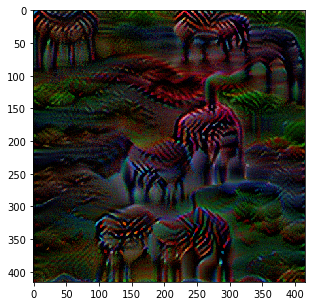

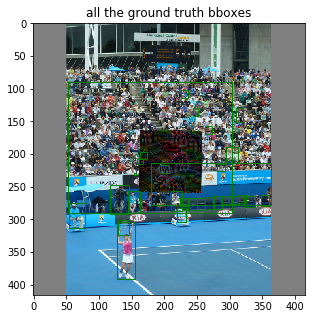

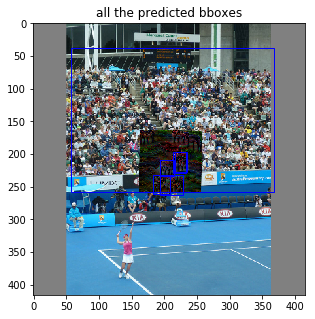

Average Precisions: {'person': 0.3170725340870603, 'bicycle': 0.1, 'car': 0.26581398942027384, 'motorbike': 0.11873840445269014, 'aeroplane': 0.03571428571428571, 'bus': 0.22875816993464052, 'train': 0.17261904761904762, 'truck': 0.05766233766233766, 'boat': 0.10887096774193548, 'traffic light': 0.18834130781499198, 'fire hydrant': 0.4444444444444444, 'stop sign': 0.4666666666666667, 'parking meter': 0.0, 'bench': 0.037065637065637064, 'bird': 0.12496762496762497, 'cat': 0.1794871794871795, 'dog': 0.08602150537634408, 'horse': 0.13954545454545456, 'sheep': 0.2127659574468085, 'cow': 0.07301587301587302, 'elephant': 0.09523809523809523, 'bear': 0.0, 'zebra': 0.0033052239814748124, 'giraffe': 0.001298863050015124, 'backpack': 0.10595238095238095, 'umbrella': 0.18518518518518515, 'handbag': 0.015151515151515152, 'tie': 0.17142857142857143, 'suitcase': 0.05757575757575758, 'frisbee': 0.12, 'skis': 0.07317073170731707, 'snowboard': 0.0, 'sports ball': 0.1509433962264151, 'kite': 0.06, 'base

In [53]:
def test_trained_patch(model):
  patch = torch.load(os.path.join(os.path.join(get_output_dir("run-2019-04-07_21:24"), "tmp/patch-epoch300.pt")))

  try:
    print_summary("patch", patch)
  except:
    print("patch shape:", patch.shape)
  
  validate(model, patch, max_iters=config["max_val_iters"], baseline=config["evaluate_baseline"])
  
model = Darknet(config["model_weights_path"], config["image_width"]).to(config["device"])
model.load_weights(config["model_weights_path"])
  
test_trained_patch(model)


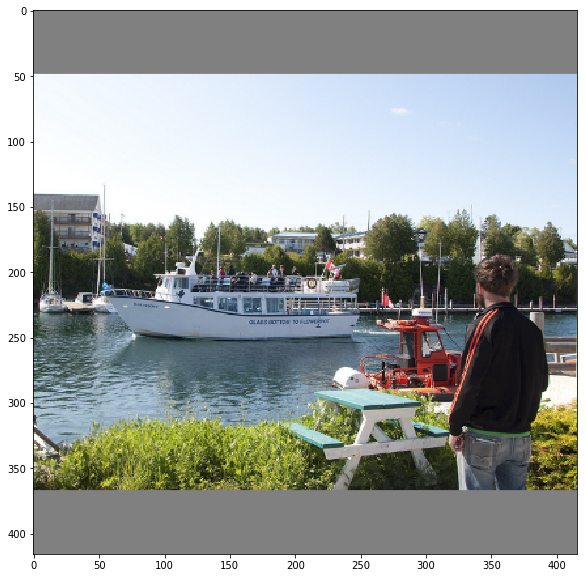

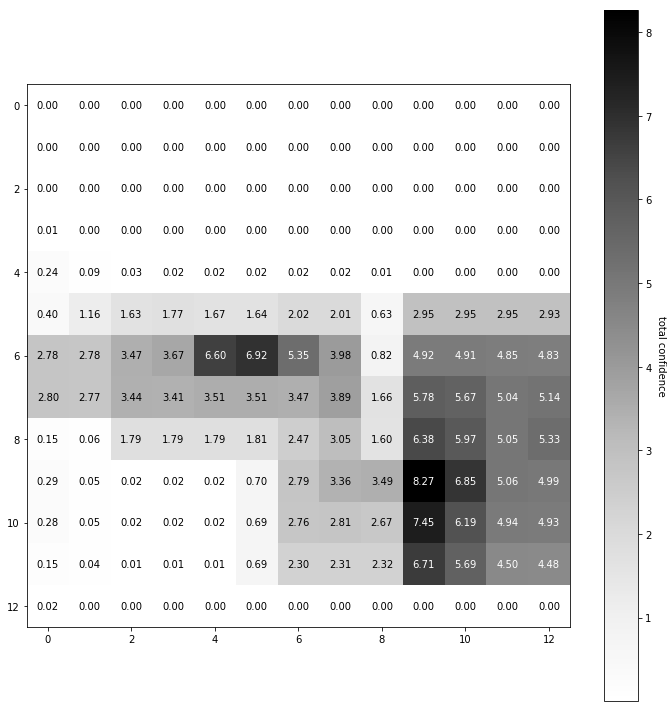

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


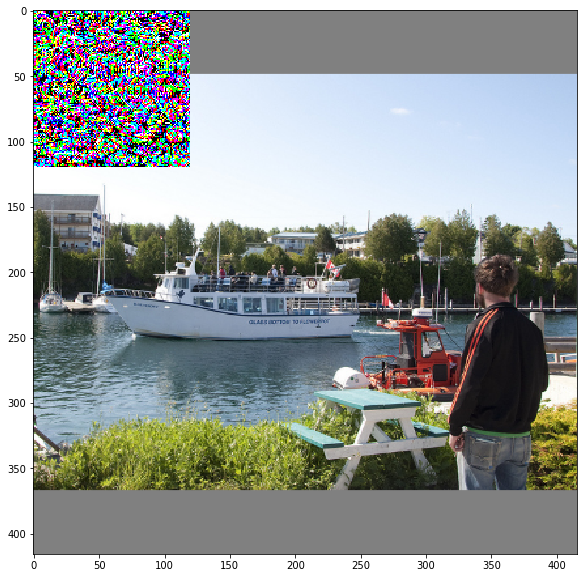

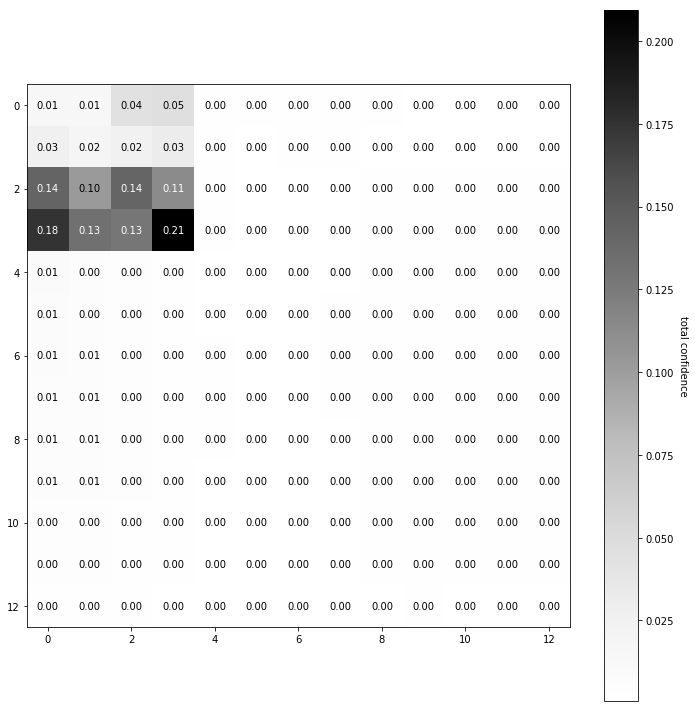

In [665]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts
  
def heatmap(bboxes, save_to=None):
  grid_size = 13
  grid_width = config["image_width"] / grid_size
  conf_values = torch.zeros((grid_size, grid_size))

  for _, x1, y1, x2, y2, conf, _ in bboxes:
    if not any([x1,y1,x2,y2,conf]):
      continue

    x1, y1 = int(x1/grid_width), int(y1/grid_width)
    x2, y2 = int(x2/grid_width) + int(x2%grid_width > 0), int(y2/grid_width) + int(y2%grid_width > 0)
    
    conf_values[y1:y2, x1:x2] += conf

  fig, ax = plt.subplots(figsize=(10,10))
  im = ax.imshow(conf_values.numpy(), cmap="Greys")

  cbar = ax.figure.colorbar(im, ax=ax)
  cbar.ax.set_ylabel("total confidence", rotation=-90, va="bottom")

  annotate_heatmap(im)

  fig.tight_layout()
  
  if save_to is not None:
    plt.savefig(save_to)
  plt.show()
  
def show_heatmap(model, image_batch, save_to=None):
  outputs = model(image_batch)
  pred_batch = non_max_suppression(outputs, config["num_classes"], conf_thres=0, nms_thres=1.)
  pred_bboxes_batch = pred_to_bbox_batch(pred_batch)
  
  for i, bboxes in enumerate(pred_bboxes_batch):    
    input_ = get_batched(image_batch[i].cpu().detach(), 1)
    annotation_ = get_batched(bboxes.cpu().detach(), 1)
  
#     show(input_.numpy(), annotation_batch=annotation_.numpy(), annotation_color="b", save_to="{}_img".format(save_to))
    show(input_.numpy(), annotation_color="b", save_to="{}_img".format(save_to))
    heatmap(bboxes, save_to="{}_heatmap".format(save_to))

def plot_heatmap(model):
  output_dir = get_output_dir("run-2019-04-14_22:45")
  patch_dir = os.path.join(output_dir, "tmp/patch-epoch580.pt")
  samples_dir = os.path.join(output_dir, "samples")
  
  if not os.path.exists(samples_dir):
    os.makedirs(samples_dir)
  
  patch = torch.load(patch_dir)
  
  image_batch, annotation_batch = get_image_batch()
  image_batch = image_batch.to(config["device"])

  save_to = os.path.join(samples_dir, "untargeted_unclipped_sample_orig")
  show_heatmap(model, image_batch.clone(), save_to=save_to)

  tform_batch = get_random_tform_batch(len(image_batch))
  input_batch, _ = apply_patch(image_batch, patch, tform_batch)

  input_batch = input_batch.to(config["device"])
  
  save_to = os.path.join(samples_dir, "untargeted_unclipped_sample_applied")
  show_heatmap(model, input_batch, save_to=save_to)

model = Darknet(config["model_weights_path"], config["image_width"]).to(config["device"])
model.load_weights(config["model_weights_path"])

plot_heatmap(model)

tensor(52)


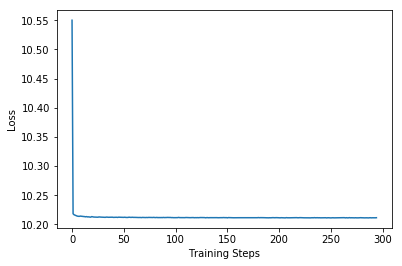

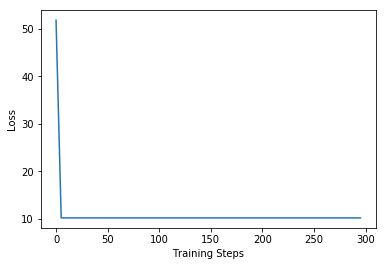

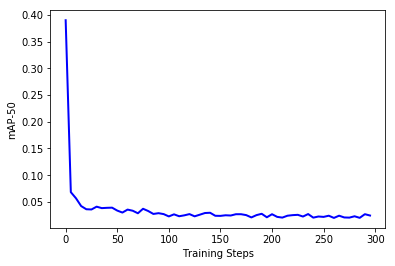

In [589]:
def show_plot(title, x, y, save_to=None, adjust=False):
  plt.title(title)
  plt.ylabel("Loss")
  plt.xlabel("Training Steps")
  plt.plot(x, y)
  if save_to is not None:
    plt.savefig(save_to)
  if adjust:
    # modify the tick labels so they represent the actual number of epochs
    plt.gca().set_xticklabels([ int(item * config["validate_every_n_epochs"]) for item in plt.gca().get_xticks() ][:-1])
  plt.show()
  
def get_output_dir(run_id):
  return os.path.join(os.path.join("outputs-device0", run_id))
#   return os.path.join(os.path.join("object-detection-dpatch-targeted-eval", run_id))

def plot_results(save=False):
#   losses_to_plot = [(1, "run-2019-04-03_15:16"), (2, "run-2019-04-05_13:19"), (3, "run-2019-04-06_17:11")]
  losses_to_plot = [(0, "run-2019-04-18_23:24")]

  # each loss_idx represents the loss function that we were actually optimizing for
  for loss_idx, run_id in losses_to_plot:
    train_plot, val_plot, AP_plot = [], [], []
    
    output_dir = get_output_dir(run_id)
    checkpoint_dir = os.path.join(output_dir, "tmp")
    plots_dir = os.path.join(output_dir, "plots")
    
    if not os.path.exists(plots_dir):
      os.makedirs(plots_dir)
    
    val_plot += torch.load("{}/val_losses-epoch{}.pt".format(checkpoint_dir, 0))
    AP_plot += torch.load("{}/APs-epoch{}.pt".format(checkpoint_dir, 0))

    for i in range(config["checkpoint_every_n_epochs"], config["max_train_epochs"]+1, config["checkpoint_every_n_epochs"]):
      train_plot += torch.load("{}/train_losses-epoch{}.pt".format(checkpoint_dir, i))
      val_plot += torch.load("{}/val_losses-epoch{}.pt".format(checkpoint_dir, i))
      AP_plot += torch.load("{}/APs-epoch{}.pt".format(checkpoint_dir, i))

    train_plot = torch.Tensor(train_plot).transpose(0,1)
    val_plot = torch.Tensor(val_plot).transpose(0,1)
    AP_plot = torch.Tensor(AP_plot).transpose(0,1)
    mAP_plot = AP_plot.mean(0)
    
    print(torch.argmin(mAP_plot))
    
    train_plot = train_plot.tolist()
    val_plot = val_plot.tolist()
    AP_plot = AP_plot.tolist()
    mAP_plot = mAP_plot.tolist()
    
    
    save_to = os.path.join(plots_dir, "untargeted_unclipped_train_loss_dpatch")
    loss_data = train_plot[0]
    show_plot("", range(len(loss_data)), loss_data, save_to=save_to if save else None)
    save_to = os.path.join(plots_dir, "untargeted_unclipped_val_loss_dpatch")
    loss_data = val_plot[0]
    show_plot("", range(len(loss_data)), loss_data, save_to=save_to if save else None, adjust=True)
    

#     # for each loss_idx, we plot all of the loss values to see how they behave under optimizing loss_idx
#     for loss_i, loss_data in enumerate(train_plot):
#       plot_title = "Train Loss {} (Optimizing {})".format(loss_i, loss_idx)
#       save_to = os.path.join(plots_dir, plot_title)
#       show_plot(plot_title, range(len(loss_data)), loss_data, save_to=save_to if save else None)
#     for loss_i, loss_data in enumerate(val_plot):
#       plot_title = "Val Loss {} (Optimizing {})".format(loss_i, loss_idx)
#       save_to = os.path.join(plots_dir, plot_title)
#       show_plot(plot_title, range(len(loss_data)), loss_data, save_to=save_to if save else None)
      
    # show AP plot for target class and mAP
#     mAP_plot_title = "APs (Optimizing {})".format(loss_idx)
#     plt.title(mAP_plot_title)
    
#     for class_i, class_APs in enumerate(AP_plot):
#       if class_i in [0,39]: # == TARGET_CLASS:
#         plt.plot(range(len(class_APs)), class_APs, 'b', linewidth=2)
# #       elif class_i < 2:
# #         plt.plot(range(len(class_APs)), class_APs)
    plt.plot(range(len(mAP_plot)), mAP_plot, 'b', linewidth=2)
  
    # modify the tick labels so they represent the actual number of epochs
    plt.gca().set_xticklabels([ int(item * config["validate_every_n_epochs"]) for item in plt.gca().get_xticks() ][:-1])
    plt.ylabel("mAP-50")
    plt.xlabel("Training Steps")
  
    if save:
      plt.savefig(os.path.join(plots_dir, "untargeted_unclipped_map_dpatch"))
    plt.show()
      
plot_results(save=True)